In [1]:
# Matplotlib for inline plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# import numpy 
import numpy as np
import scipy as sp


<matplotlib.colorbar.Colorbar instance at 0x7f8b8fed1f38>

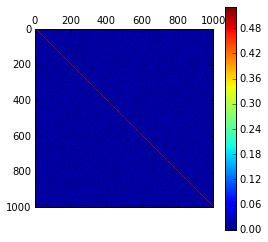

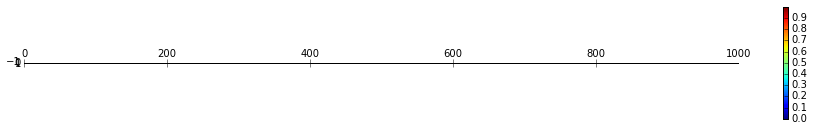

In [2]:
# Define a quadratic optimization  min(.5 * x^t P x + q^t x + r)

## problem size
N = 1000

## Define the array P
P = .5 * np.eye(N) 
R = 1.0/sp.sqrt(float(N)) * sp.rand(N,N)
P += (R + R.T) / 2.0

## Define the vector q
q = sp.rand(N)

## Define r
r = sp.rand(1)

## print the parameters
plt.matshow(P); plt.colorbar()
plt.matshow(q.reshape(1, -1)); plt.colorbar()


In [3]:
# Define the function 
def indom(x, N):
    "Return true if in domain."
    if x.size == N: 
        return True
    else:
        return False
    
def f(x, P=P, q=q, r=r):
    "Quadratic function to minimize."
    out = 1.0 / 2.0 * np.dot(x, np.dot(P, x)) + np.dot(q, x) + r
    return out

def Df(x, P=P, q=q, r=r):
    "Return the gradient."
    out = np.dot(P, x) + q
    return out

def Hf(x, P=P, q=q, r=r): 
    "Return the hessian."
    return P
    
class InitF(object):
    """
    Constructor for CVXOPT style model.
    """
    
    def __init__(self, x0, f=f, Df=Df, Hf=Hf, indom=indom):
        "Define the CVXOPT model."
        self.N = x0.size
        self.x0 = x0
        self.indom=indom
        self.f = f
        self.Df = Df
        self.Hf = Hf
        
    def __call__(self, *args):
        "Define the function expeted by CVXOPT"

        # No arguments passed, return the initial guess
        if len(args) == 0:
            if self.indom(self.x0, self.N) is False:
                return (None, None)
            elif self.indom(self.x0, self.N) is True:
                f = self.f(x0)
                if np.isscalar(f):
                    K = 1
                else:
                    K = f.size
                return (K, self.x0)
        
        # One argument passed, return the objective value and gradient
        if len(args) == 1:
            x = args[0]
            indom = self.indom(x, self.N)
            if indom is False:
                return (None, None)
            elif indom is True:
                out = (self.f(x), self.Df(x))
                return out
            
        # Two values passed, 
        if len(args) == 2:
            x, z = args[:]
            f = self.f(x)
            Df = self.Df(x)
            H = sp.zeros((self.N, self.N))
            H[:,:] = np.tensordot(z, self.Hf(x).reshape(-1, N, N), axes=[(0,), (0,)])
            return (f, Df, H)
        
# Check the output of the functions
x0 = sp.rand(N)
F = InitF(x0)
#print("{}\n{}".format(*F()))
#print("{}\n{}".format(*F(x0)))
#print("{}\n{}\n{}".format(*F(x0, sp.array([1]))))



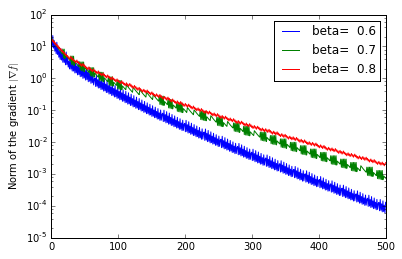

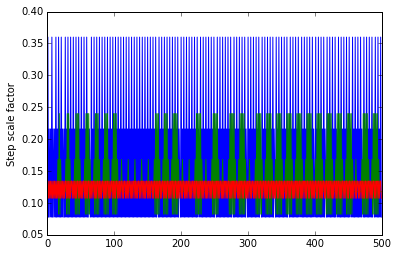

In [8]:
# Run gradient descent
x0 = np.zeros(N)
F = InitF(x0)

# Initialize an algorithm 
K, x0 = F()

t0 = 1.0
alpha = .5
beta = .8


def get_steps(M, t0, alpha, beta, F=F):

    xs = np.zeros((M+1, N))
    ys = np.zeros(M+1)
    ts = np.zeros(M)
    dxs = np.zeros((M, N))

    for i in range(ts.size):

        x = xs[i]
        f, df = F(x)
        ys[i] = f
    
        # calculate the step
        dx = -df

        # compute step length

        ## Initial guess for step length
        t = t0
        xnew = x + t * dx
        fnew = F.f(xnew)
        
        ## Check condition for bactracking
        tgood = fnew < f + alpha * t * np.dot(df, dx)      
        count = 0
        
        ## Backtrack t = beta * t until the condition holds
        while (tgood == False) and (count < 50):
            count += 1 
            t *= beta
            xnew = x + t * dx
            fnew = F.f(xnew)
            tgood = fnew < f + alpha * t * np.dot(df, dx)  
        count = 0
        
        
        # updatae everything
        ts[i] = t
        dxs[i] = dx
        xs[i+1] = xnew

    else:
        f = F.f(x)
        ys[i+1] = f  
    
    # define output
    return xs, ys, ts, dxs
    
# get steps
betas = sp.linspace(.6, .8, 3)

steps = 500
out_list = [get_steps(steps, 1.0, .25, _beta) for _beta in betas]
    
#plt.plot(ys)
for beta, (xs, ys, ts, dxs) in zip(betas, out_list):
    plt.figure(0)
    plt.semilogy(np.sqrt((dxs*dxs).sum(1)), label='beta={0:5.2}'.format(beta))
    
    plt.figure(1)
    plt.plot(ts)

    plt.figure(2)
#    for i in range(N):
#        plt.plot(xs[:,i], marker='x', linewidth=.5)
#    plt.plot(steps * sp.ones_like(xs[-1,:]), xs[-1,:], marker='o', markersize=15)
        


plt.figure(2)    
#plt.plot(*xout[:2].T, marker='o')
#plt.plot(*xout[::2].T, marker='o')
    
    
plt.figure(1)
plt.ylabel(r"Step scale factor")
    
plt.figure(0)
plt.ylabel(r'Norm of the gradient $|\nabla f|$')
plt.legend(loc='best')